In [1]:
import os
from pathlib import Path
from typing import Callable
import warnings

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from segregation.aspatial import MinMax, Dissim
import rasterio as rio
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

data_dir = Path('../data')


In [2]:
def get_xy(
        geodf: gpd.GeoDataFrame,
        geometry_col: str = None,
) -> gpd.GeoDataFrame:

    if not geometry_col:
        geometry_col = geodf.geometry.name

    if geodf[geometry_col].geom_type[0] == 'Point':
        geodf['x'] = geodf[geometry_col].apply(lambda geom: geom.x)
        geodf['y'] = geodf[geometry_col].apply(lambda geom: geom.y)
    else:
        geodf['x'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[0]))
        geodf['y'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[1]))
    return geodf

def kernel_density_surface(
        data: gpd.GeoDataFrame,
        group: str,
        bandwidth,
        cell_size,
        kernel_function: Callable,
):
    pop = get_xy(data)
    pad = bandwidth * 2

    minx, miny, maxx, maxy = pop.geometry.total_bounds

    minx -= pad
    miny -= pad
    maxx += pad
    maxy += pad

    x = np.arange(minx, maxx, cell_size)
    y = np.arange(miny, maxy, cell_size)

    X, Y = np.meshgrid(x, y)

    xy = np.vstack([Y.ravel(), X.ravel()]).T

    U = cdist(xy, pop[['y', 'x']].values, metric='euclidean')
    W = kernel_function(U, bandwidth=bandwidth)

    density = (W * pop[group].values).sum(axis=1).reshape(X.shape)

    geotiff_meta = {
        'driver': 'GTiff',
        'count': 1,
        'dtype': 'float64',
        'width': len(x),
        'height': len(y),
        'crs': data.crs,
        'transform': rio.transform.from_bounds(
            west=minx,
            east=maxx,
            north=maxy,
            south=miny,
            width=len(x),
            height=len(y),
        )
    }

    return density[::-1, ], geotiff_meta

def point_value(point: Point, raster: rio.DatasetReader):
    x, y = point.x, point.y
    r, c = raster.index(x, y)
    value = raster.read(1)[r, c]

    return value

def quartic_kernel(u, bandwidth):
    return np.where(
            np.abs(u) <= bandwidth,
            3 / (np.pi * bandwidth * bandwidth) * (1 - (u / bandwidth) ** 2) ** 2,
            0
    )

In [3]:
def prepare_pop_data(
        population_data: pd.DataFrame,
        num_cols=None,
) -> pd.DataFrame:

    pop_frame = population_data.fillna(value=0)

    if not num_cols:
        num_cols = [
            'total_men',
            'total_women',
            'orthodox',
            'other_christian',
            'other_religion',
        ]

    pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)

    pop_frame['lutheran'] = pop_frame['total_men total_women'.split()].sum(axis=1) \
                            - pop_frame['other_christian orthodox other_religion'.split()].sum(axis=1)

    pop_frame['total'] = pop_frame['other_christian orthodox other_religion lutheran'.split()].sum(axis=1)

    return pop_frame

def remove_institutions(
        pop_data: pd.DataFrame,
        institutions: pd.DataFrame,
        year,
):
    institutions = institutions.set_index(['district', 'plot_number'])
    institutions = institutions.loc[institutions.year == year]

    for idx in institutions.index:
        pop_data = pop_data.drop(index=idx, errors='ignore')

    return pop_data

def split_plots(
        geodataframe: gpd.GeoDataFrame,
        target_col: str,
        separator: str = ',',
) -> gpd.GeoDataFrame:

    new_geodataframe = gpd.GeoDataFrame(columns=geodataframe.columns)

    for _, row in geodataframe.iterrows():
        plots = str(row[target_col]).split(separator)

        if len(plots) < 2:
            new_geodataframe = new_geodataframe.append(row)
            continue

        for plot in plots:
            new_row = row
            new_row[target_col] = plot
            new_geodataframe = new_geodataframe.append(new_row)

    assert len(new_geodataframe.index) == len(list(pd.core.common.flatten(
        [
            str(w).split(separator)
            for w
            in geodataframe[target_col]
        ]))), 'splitting failed'

    return new_geodataframe.reindex()

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

location_data = gpd.read_file(data_dir / 'raw' / 'plots_1878.shp').to_crs(epsg=3067)
location_data = split_plots(location_data, target_col='NUMBER')
location_data['district'] = [district_codes[int(d)] for d in location_data['DISTRICT']]
location_data['plot_number'] = [str(i) for i in location_data['NUMBER']]
location_data = location_data.set_index(['district', 'plot_number'])
city = gpd.read_file(data_dir / 'raw' / 'city_1846.shp').to_crs(epsg=3067)
location_data = location_data.loc[~location_data.geometry.within(city.geometry[0]).index.duplicated()]
location_data = location_data.loc[location_data.geometry.within(city.geometry[0])]

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}

lutheran_density = rio.open('../data/processed/lutheran_density_1880_150_m.tif')
orthodox_density = rio.open('../data/processed/orthodox_density_1880_150_m.tif')
total_density = rio.open('../data/processed/total_density_1880_150_m.tif')
location_data['lutheran_density'] = location_data.geometry.apply(point_value, raster=lutheran_density).round(4)
location_data['orthodox_density'] = location_data.geometry.apply(point_value, raster=orthodox_density).round(4)
location_data['total_density'] = location_data.geometry.apply(point_value, raster=total_density).round(4)
location_data.drop(columns=['DISTRICT', 'NUMBER'], inplace=True)

In [5]:
income = pd.read_csv(data_dir / 'interim' / 'income_tax_record_1880.csv', index_col=0)
income.plot_number = income.plot_number.apply(lambda i: i.split(',')[0] if isinstance(i, str) else i)
income.set_index(['district', 'plot_number'], drop=True, inplace=True)
income['total_income'] = income.loc[:,
                         ['estate_income', 'business_income', 'salary_pension_income']
                         ].sum(axis=1)

In [6]:
income.describe()

,estate_income,business_income,salary_pension_income,total_income
count,3336.000000,3336.000000,3336.000000,3336.000000
mean,0.826739,1.786271,2.419964,5.032974
std,3.067548,16.865182,6.133464,18.756135
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000
75%,0.000000,0.000000,2.000000,3.000000
max,40.000000,554.000000,115.000000,562.000000


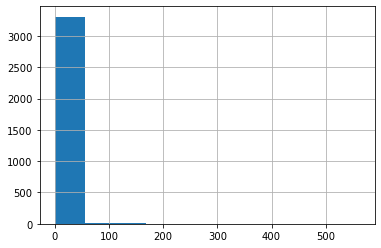

In [7]:
income.total_income.hist()
plt.show()

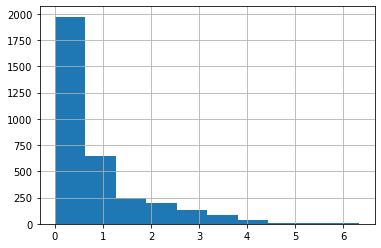

In [8]:
income['total_income_log'] = income.total_income.apply(lambda x: np.log(x) if x > 0 else 0).round(4)
income.total_income_log.hist()
plt.show()

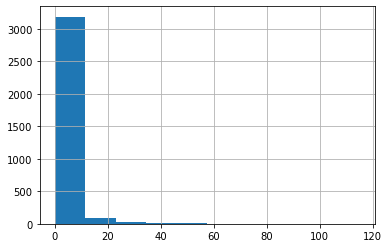

In [9]:
income.salary_pension_income.hist()
plt.show()

In [10]:
income = income.groupby(level=[0, 1]).sum()
income_types = 'estate_income business_income salary_pension_income total_income'.split()
combined_data = location_data.join(income)

for it in income_types:
    combined_data[it] = combined_data[it].fillna(0)

for it in income_types:
    kde, raster_args = kernel_density_surface(
            data=combined_data,
            group=it,
            bandwidth=150,
            cell_size=25,
            kernel_function=quartic_kernel,
    )
    kde = kde * 10_000

    file = f'../data/processed/{it}_1880.tif'

    with rio.open(file, 'w', **raster_args) as rfile:
        rfile.write(kde, 1)

for it in income_types:
    income_density = rio.open(f'../data/processed/{it}_1880.tif')
    location_data[it] = location_data.geometry.apply(point_value, raster=income_density).round(4)

population_data = pd.read_csv(
    data_dir / 'interim' / f'pop_by_plot_1880.csv',
    index_col=0,
    dtype={'district': str, 'plot_number': str},
).pipe(prepare_pop_data)

population_data = population_data.set_index(['district', 'plot_number'], drop=True)
population_data = population_data.pipe(remove_institutions, institutions, 1880)
population_data = population_data.groupby(level=[0, 1]).sum()

combined_data = combined_data.join(population_data)
print(combined_data.corr())
print(combined_data.tail(100))
combined_data.reset_index(inplace=True, drop=False)
combined_data.to_file('../data/processed/spatial_income_1880.shp')


                       lutheran_density  orthodox_density  total_density  \
lutheran_density               1.000000          0.694554       0.994577   
orthodox_density               0.694554          1.000000       0.765064   
total_density                  0.994577          0.765064       1.000000   
estate_income                  0.257190          0.248232       0.265896   
business_income                0.175286          0.214289       0.188483   
salary_pension_income          0.194607          0.131005       0.193268   
total_income                   0.236412          0.240593       0.246875   
total_income_log               0.211996          0.255300       0.231099   
x                             -0.105145         -0.270532      -0.131405   
y                             -0.107209          0.172193      -0.071872   
taxpayer_men                   0.219329          0.172451       0.223592   
taxpayer_women                 0.217829          0.198991       0.227204   
no_tax_men  